In [33]:
import pandas as pd
from pathlib import Path
import numpy as np
from predcontrol_sf.data_loader import load_data_bom_aus
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
data_folder = Path(r"C:\Users\sgnodde\Documents\data\data_stony_creek_at_spotswood")

In [127]:
rainfall = load_data_bom_aus(data_folder/'stonycreek_rainfall.csv')
discharge = load_data_bom_aus(data_folder/'stonycreek_discharge.csv')
level = load_data_bom_aus(data_folder/'stonycreek_level.csv')

In [128]:
import lightgbm as lgb

## Build dataset

In [219]:
data = discharge[['Value']].copy().rename(columns={'Value':'discharge'})
data = data.resample('30min').mean()
data['rainfall'] = rainfall['Value'].resample('30min').mean()

data['rainfall'] = data['rainfall'].bfill(limit=2)
data['rainfall'] = data['rainfall'].fillna(0)

# Fake predictions: 
data['rainfall_pred_1'] = data['rainfall'].shift(-2)+np.random.gumbel(loc=0.0, scale=.5, size=len(data))
data['rainfall_pred_1'][data['rainfall_pred_1'] < 0] = 0
data['rainfall_pred_1'][data['rainfall'].shift(-2) < 1] = data['rainfall_pred_1'][data['rainfall'].shift(-2) < 1]/10 

data['rainfall_pred_2'] = data['rainfall'].shift(-4)+np.random.gumbel(loc=0.0, scale=.8, size=len(data))
data['rainfall_pred_2'][data['rainfall_pred_2'] < 0] = 0
data['rainfall_pred_2'][data['rainfall'].shift(-4) < 1] = data['rainfall_pred_2'][data['rainfall'].shift(-4) < 1]/10 

data['discharge'] = data['discharge'].interpolate()


data['level'] = level['Value'].resample('30min').mean()
data['level'] = data['discharge'].interpolate()
data['level_diff'] = data['level'].diff()
data['level_diff_2'] = data['level'].diff(2)

DAYS_IN_YEAR = 365.25
norm_index = 2 * np.pi * data.index.dayofyear / DAYS_IN_YEAR
data['sin_day'] = np.sin(norm_index)
data['cos_day'] = np.cos(norm_index)
for i in [3,9,20]:
    for column in ['discharge', 'rainfall']:
        data[f'{column}_rolling_{i}'] = data[column].rolling(i).mean()
data['target'] = data['discharge'].shift(-4)

data = data.dropna()

data_train = data.loc[:"2016"]

data_valid = data.loc["2017":"2019"]
data_test = data.loc["2020":]
X_train = data_train.drop(columns="target")
y_train = data_train['target']
X_valid = data_valid.drop(columns="target")
y_valid = data_valid["target"]



<AxesSubplot:>

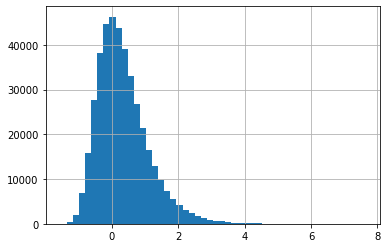

In [220]:
pd.Series(np.random.gumbel(loc=0.0, scale=.6, size=len(data))).hist(bins=50)

(0.0, 100.0)

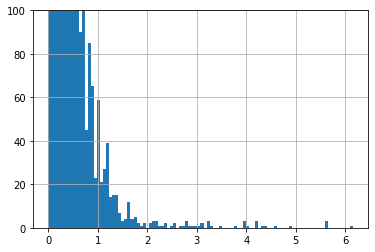

In [221]:
data['rainfall'].hist(bins=100)
plt.ylim(0,100)

In [222]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [223]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [224]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

print('Saving model...')
# save model to file
gbm.save_model('model.txt')



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 0.174261	valid_0's l1: 0.073816
Saving model...


In [225]:
print('Starting predicting...')
# predict
y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
# eval
r2_valid = r2_score(y_valid, y_pred)
print(f'The R2 score of prediction is: {r2_valid}')

Starting predicting...
The R2 score of prediction is: 0.41684836585205076


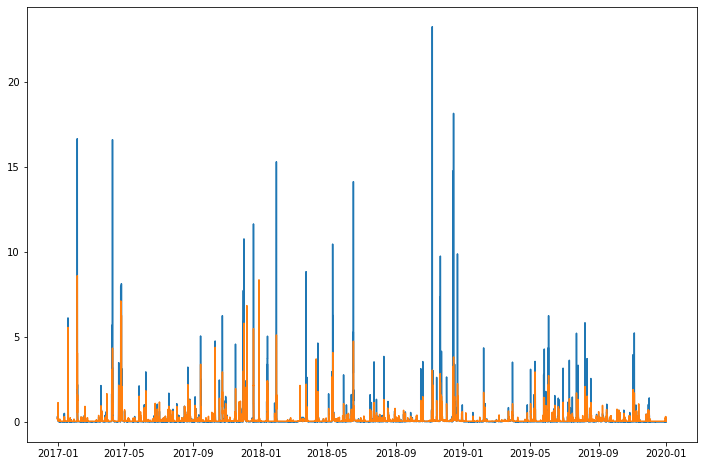

In [197]:
plt.figure(figsize=(12,8))

plt.plot(y_valid)
plt.plot(pd.Series(y_pred, index=y_valid.index))


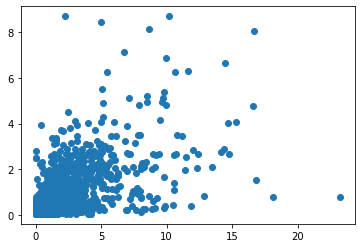

In [135]:
plt.scatter(y_valid, pd.Series(y_pred, index=y_valid.index))

In [136]:
r2_score(y_valid[4:], y_valid.shift(4)[4:])

0.27500979898142297

<AxesSubplot:xlabel='date'>

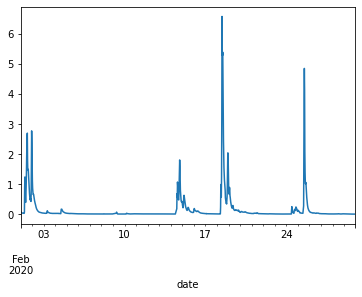

In [137]:
data['target']['2020-02'].plot()

<AxesSubplot:xlabel='date'>

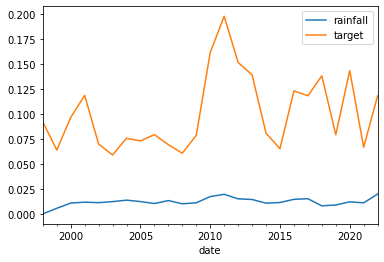

In [138]:
data[['rainfall','target']].resample('y').mean().plot()

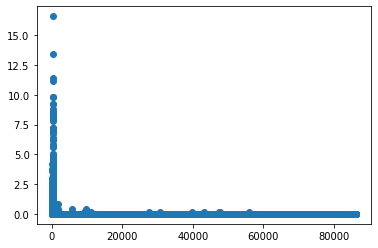

In [8]:
plt.scatter(rainfall.index.to_series().diff().dt.seconds, rainfall['Value'])





In [11]:
np.corrcoef(rainfall_2.index.to_series().diff().dt.seconds, rainfall_2['Value'])


array([[nan, nan],
       [nan,  1.]])

In [13]:
corr_df = rainfall[['Value']]
corr_df['gap'] = rainfall.index.to_series().diff().dt.seconds
corr_df = corr_df.dropna()
corr_df.corr()

C:\Users\sgnodde\AppData\Local\Temp/ipykernel_20176/361827962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df['gap'] = rainfall.index.to_series().diff().dt.seconds


,Value,gap
Value,1.000000,-0.175823
gap,-0.175823,1.000000


In [12]:
rainfall_2

,Value,Quality Code,Interpolation Type
date,,,
1999-06-03 23:54:00+10:00,0.0,210,201
1999-06-04 00:00:00+10:00,0.0,10,201
1999-06-04 00:06:00+10:00,0.0,210,201
1999-06-07 08:06:00+10:00,0.0,210,201
1999-06-07 10:18:00+10:00,0.0,210,201
...,...,...,...
2022-01-08 08:03:00+10:00,0.2,140,201
2022-01-08 15:00:00+10:00,0.0,140,201
2022-01-08 15:01:00+10:00,0.2,140,201


In [10]:
rainfall_2 = rainfall.dropna()

In [17]:
rainfall['Value'].resample('30min').mean().isna().mean()

0.9453269683956623

In [23]:
rainfall['Value'].resample('2h').mean().isna().mean()

0.8772682316371637

In [18]:
rainfall

,Value,Quality Code,Interpolation Type
date,,,
1999-06-03 23:54:00+10:00,0.0,210,201
1999-06-04 00:00:00+10:00,0.0,10,201
1999-06-04 00:06:00+10:00,0.0,210,201
1999-06-07 08:06:00+10:00,0.0,210,201
1999-06-07 10:18:00+10:00,0.0,210,201
...,...,...,...
2022-01-08 08:03:00+10:00,0.2,140,201
2022-01-08 15:00:00+10:00,0.0,140,201
2022-01-08 15:01:00+10:00,0.2,140,201
